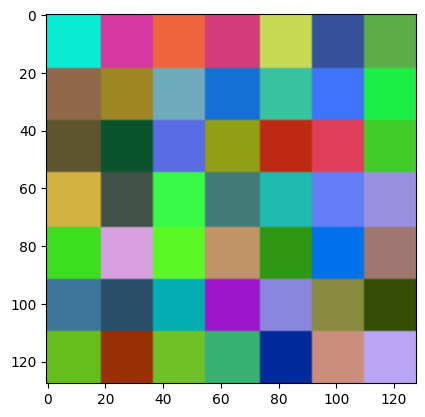

In [1]:
# image mapping
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torch

src = np.random.randint(0,256,(7,7,3),dtype=np.uint8)
src = cv2.resize(src,(128,128),interpolation=cv2.INTER_NEAREST)
plt.imshow(src)

> method for single mapping & inverse mapping

In [2]:
def get_inv_FCG_mapping(nr,pmax,p0,c_gaze, dtype=np.int32):
    """
    Returns inverse mapping of Foveal Cartesian Geometry.
    This inverse mapping is required for the cv2::remap to perform foveation
    
    Parameters
    nr : Integer
        Number of rings, not including fovea. nr > 0.
    pmax : Integer
        Maximum distance where the last ring should be positioned. Pixel unit. pmax > p0.
    p0 : Integer
        Fovea radius. Pixel Unit. p0 > 0
    c_gaze : (Integer, Integer)
        In (x0, y0) shape. Center point of gaze in src image.
    dtype : str or dtype
        Typecode or data-type to which the returned arrays are cast. default np.int32
        
    Returns
        X, Y : ndarray
        inverse mapping X and Y. arrays are the same size with the foveated image.
    """
    # factor a
    a = math.exp(1/nr*math.log(pmax/p0))
    # Delta p(Xi)
    delta_p = lambda xi: (p0*a**xi)/(p0+xi) # xi = 1,2,...,Nr
    x0, y0 = c_gaze
    # center point of foveated image
    fcx = fcy = p0+nr
    # get meshgrid of x' and y' to use np
    dx = np.arange(0,(p0+nr)*2+1)
    dy = np.arange(0,(p0+nr)*2+1)
    X_out, Y_out = np.meshgrid(dx,dy) # _out is equal to ' in Table 1.
    # inverse mapping algorithm as in Table 1.
    X_out = X_out - fcx
    Y_out = Y_out - fcy
    R = np.max(np.stack((np.abs(X_out),np.abs(Y_out))),axis=0)
    # In the paper, case where r <= p0 is defined separately.
    # However, it is not necessary if XI = 0 for XI < 0
    XI = np.clip(R-p0,0,nr)
    X = np.floor(X_out*delta_p(XI)+x0).astype(dtype)
    Y = np.floor(Y_out*delta_p(XI)+y0).astype(dtype)
    return X,Y

def get_FCG_revertFunc(nr,p0,pmax):
    # steps
    # undo foveation
    a = math.exp(1/nr*math.log(pmax/p0))
    delta_p = lambda xi: (p0*a**xi)/(p0+xi) # xi = 1,2,...,Nr
    # coordinates x and y can be reverted
    # to revert radius, multiply by the ratio of D_origin/D_fov
    def revertFunc(x, size):
        # x - tensor of shape (B,), in pixel coor
        x = x-size/2
        xi = x.clip(torch.abs(x)-p0,0,nr)
        x = x*delta_p(xi)
        # outputs x in pixel coord, origin at the center of fovea
        # scale then translate the output to get the original image coord 
        return x
    # undo scale
    # undo translate 

def get_FCG_mapping(nr,pmax,p0,c_gaze,src_size,dtype=np.int32):
    """
    Returns the mapping of Foveal Cartesian Geometry.
    This mapping is required for the cv2::remap to perform recovery from foveated image
    
    Parameters
    nr : Integer
        Number of rings, not including fovea. nr > 0.
    pmax : Integer
        Maximum distance where the last ring should be positioned. Pixel unit. pmax > p0.
    p0 : Integer
        Fovea radius. Pixel Unit. p0 > 0
    c_gaze : (Integer, Integer)
        In (x0, y0) shape. Center point of gaze in src image.
    src_size : (Integer,Integer)
        (height, width) of the src image.
    dtype : str or dtype
        Typecode or data-type to which the returned arrays are cast. default np.int32
        
    Returns
        X_out, Y_out : ndarray
        The mapping X and Y. arrays are the same size with the src image.
    """
    # factor a
    a = math.exp(1/nr*math.log(pmax/p0))
    # Delta p(Xi)
    delta_p = lambda xi: (p0*a**xi)/(p0+xi) # xi = 1,2,...,Nr
    x0, y0 = c_gaze
    h, w = src_size
    # center point of foveated image
    fcx = fcy = p0+nr
    # get meshgrid of x and y to use np
    dx = np.arange(0,w)
    dy = np.arange(0,h)
    X, Y = np.meshgrid(dx,dy)
    # mapping algorithm as in Table 1.
    X = X-x0
    Y = Y-y0
    # distance map
    P = np.max(np.stack((np.abs(X),np.abs(Y))),axis=0)
    # if-else clause can be defined simultaneously if 
    # (p = p0 for p <= p0) and (p = pmax for p >= pmax)
    P = np.clip(P,p0,pmax)
    XI = np.floor(np.log(P/p0)/np.log(a))
    X_out = np.floor(X/delta_p(XI)+fcx).astype(dtype)
    Y_out = np.floor(Y/delta_p(XI)+fcy).astype(dtype)
    return X_out, Y_out

In [3]:
# changed numpy to torch
def batch_remap(src, base, scale, translate, borderValue=0):
    """
    cv2.remap like operation using tensor indexing.
    Remap implementation for batch operation
    
    Parameters
    src : torch.tensor
        source batch. Expected to be (B,C,H,W)
    base : torch.tensor
        Tuple of (X_mapping, Y_mapping). mappings must be numeric
    scale : Tensor of shape (B,2). 
        scale(zoom) coefficient for each image in batch. x, y order
    translate : Tensor of shape (B,2)
        x y translate for each image in batch. 
    borderValue : Integer
        border fill. TODO) also allow per channel value
    """
    b,c,h,w = src.shape
    out = []
    for maps, sc, tr, dim in zip(base,scale.T,translate.T,(w,h)):
        # apply scale and translate
        maps = (maps.repeat(b,1,1) * sc.view(b,1,1)
                + tr.view(b,1,1)).to(torch.int32)
        off_border = torch.logical_or(maps<0,maps>=dim)
        # since python allows negative indexing, use -1 as a off_border flag
        out.append(maps*(~off_border) - 1*(off_border))
    
    X, Y = out
    b_idx = torch.arange(b).view(b,1,1,1)
    c_idx = torch.arange(c).view(c,1,1)
    # apply mapping to the src
    dst = src[b_idx,c_idx,Y.unsqueeze(1),X.unsqueeze(1)]
    # fill border
    off_border = torch.logical_or(X < 0, Y < 0).unsqueeze(1)
    dst = dst*(~off_border) + borderValue*off_border
    
    return dst


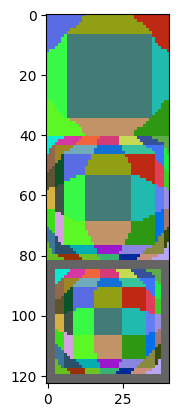

In [4]:
X, Y = get_inv_FCG_mapping(nr=10,pmax=50,p0=10,c_gaze=(0,0))

if torch.cuda.is_available():
    X = torch.tensor(X).cuda()
    Y = torch.tensor(Y).cuda()
else:
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
h,w,c = src.shape
b = 3

b_scale = torch.linspace(.5,2,b).view(-1,1).repeat_interleave(2,1)
b_translate = torch.ones((b,2))*64
b_src = torch.permute(torch.tensor(src),(2,0,1)).repeat((b,1,1,1))

if torch.cuda.is_available():
    b_src = b_src.cuda()
    b_scale = b_scale.cuda()
    b_translate = b_translate.cuda()

b_fov = batch_remap(b_src, base=(X,Y), 
                    scale=b_scale, 
                    translate=b_translate,
                    borderValue=100)
      
# viz
b_fov = b_fov[:3] if len(b_fov) > 3 else b_fov
fov_viz = torch.cat([torch.permute(fov,(1,2,0)) for fov in b_fov])
plt.imshow(fov_viz)

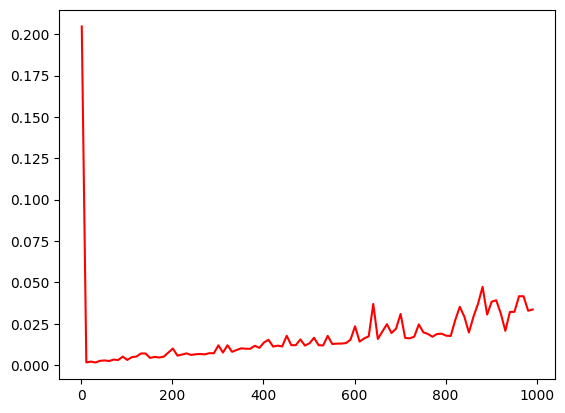

In [4]:
X, Y = get_inv_FCG_mapping(nr=10,pmax=50,p0=10,c_gaze=(0,0))

if torch.cuda.is_available():
    X = torch.tensor(X).cuda()
    Y = torch.tensor(Y).cuda()
else:
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
h,w,c = src.shape

import time
t_list = []
bmax = 1000


for b in range(1,bmax,10):

    b_scale = torch.linspace(.5,2,b).view(-1,1).repeat_interleave(2,1)
    b_translate = torch.ones((b,2))*64
    b_src = torch.permute(torch.tensor(src),(2,0,1)).repeat((b,1,1,1))
    
    if torch.cuda.is_available():
        b_src = b_src.cuda()
        b_scale = b_scale.cuda()
        b_translate = b_translate.cuda()

    t0 = time.time()

    b_fov = batch_remap(b_src, base=(X,Y), 
                        scale=b_scale, 
                        translate=b_translate,
                        borderValue=100)
    
    t_list.append(time.time()-t0)

plt.plot(range(1,bmax,10),t_list,'r-')
plt.show()

# RESULT ---------
# for b=1000, cpu took ~0.13 whereas gpu took ~0.025
    
# viz
# b_fov = b_fov[:3] if len(b_fov) > 3 else b_fov
# fov_viz = torch.cat([torch.permute(fov,(1,2,0)) for fov in b_fov])
# plt.imshow(fov_viz)

In [ ]:
X_out, Y_out = get_FCG_mapping(nr=10,pmax=100,p0=20,c_gaze=(96,96),
                               src_size=src.shape[:2],dtype=np.int32)

b_recov = batch_remap(b_fov,X_out,Y_out,borderValue=100)
print(b_recov.shape)

# transpose fov for viz
b_recov_viz = np.transpose(b_recov.reshape((3,*b_recov.shape[2:])),(1,2,0))
plt.imshow(b_recov_viz)

In [ ]:
X, Y = get_inv_FCG_mapping(nr=10,pmax=100,p0=20,c_gaze=(96,96),
                           dtype=np.float32)
fov = cv2.remap(src,X,Y,
               interpolation=cv2.INTER_NEAREST,
               borderMode=cv2.BORDER_CONSTANT, borderValue=100)
plt.imshow(fov)

In [ ]:
X_out, Y_out = get_FCG_mapping(nr=10,pmax=100,p0=20,c_gaze=(96,96),
                               src_size=src.shape[:2],dtype=np.float32)
recov = cv2.remap(fov,X_out,Y_out,
               interpolation=cv2.INTER_AREA,
               borderMode=cv2.BORDER_CONSTANT, borderValue=100)
plt.imshow(recov)